MLP Classifier for Production Data (3 Classes)
Datasets loaded successfully from session upload
Training data shape: 3584 samples and 84 features
Validation data shape: 768 samples and 84 features
Test data shape: 768 samples and 84 features
Production data categorized into 3 classes: low, medium, high

Class distribution in training data:
high: 1219 samples (34.0%)
low: 1184 samples (33.0%)
medium: 1181 samples (33.0%)
Data preparation completed

Building and training MLP classifier...
Model training completed in 211 iterations
Final loss: 0.001844

Model Evaluation Metrics:
----------------------------------------
Training accuracy: 1.0000
Validation accuracy: 0.9115
Test accuracy: 0.9219
Precision (micro): 0.9219
Precision (macro): 0.9270
Precision (weighted): 0.9263
Recall (micro): 0.9219
Recall (macro): 0.9218
Recall (weighted): 0.9219
F1 Score (micro): 0.9219
F1 Score (macro): 0.9230
F1 Score (weighted): 0.9227

Detailed Classification Report:
              precision    recall  f

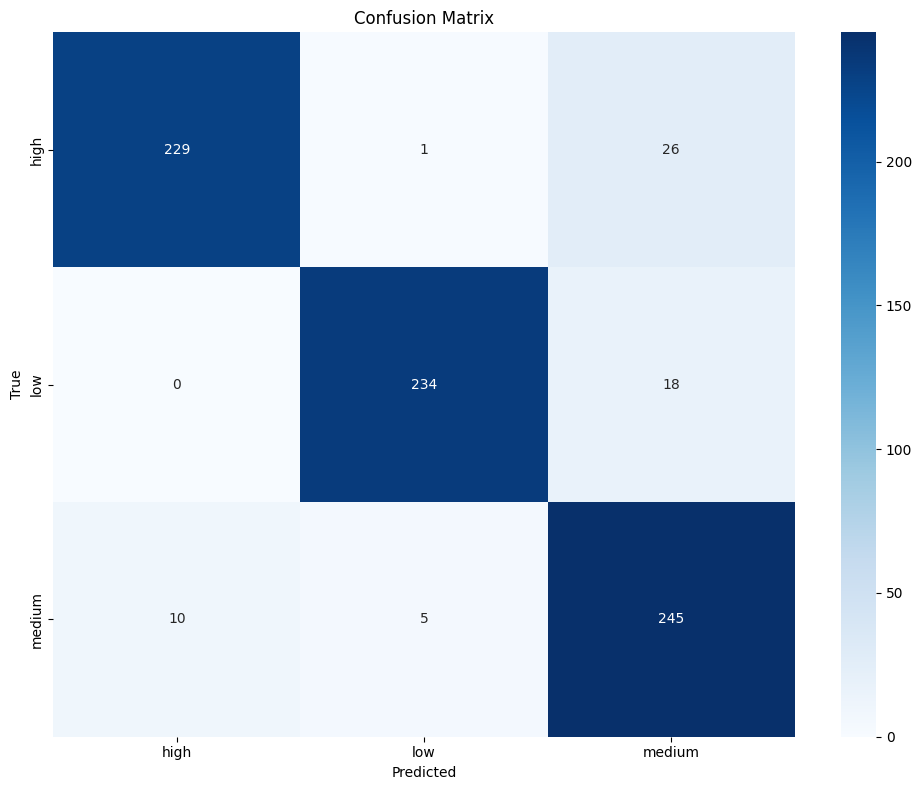


MLP Classification with 3 classes completed successfully!


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

def load_data(train_path='train.csv', validation_path='validation.csv', test_path='test.csv'):
    """
    Load the datasets from session upload

    Args:
        train_path: Path to the training CSV file
        validation_path: Path to the validation CSV file
        test_path: Path to the test CSV file

    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and test data
    """
    # Load the datasets
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(validation_path)
    test_df = pd.read_csv(test_path)

    print(f"Datasets loaded successfully from session upload")
    print(f"Training data shape: {train_df.shape[0]} samples and {train_df.shape[1]} features")
    print(f"Validation data shape: {val_df.shape[0]} samples and {val_df.shape[1]} features")
    print(f"Test data shape: {test_df.shape[0]} samples and {test_df.shape[1]} features")

    return train_df, val_df, test_df

def categorize_production(train_df, val_df, test_df):
    """
    Categorize production values into 3 classes (Low, Medium, High)

    Args:
        train_df, val_df, test_df: DataFrames with production data

    Returns:
        train_df, val_df, test_df: DataFrames with added category column
        le: LabelEncoder object for the categories
    """
    # Define thresholds based on 33rd and 66th percentiles of training data
    quantiles = np.quantile(train_df['Production (M.Ton)'], [0.33, 0.66])

    # Create a function to assign categories
    def assign_category(value):
        if value <= quantiles[0]:
            return 'low'
        elif value <= quantiles[1]:
            return 'medium'
        else:
            return 'high'

    # Apply the function to create a new column in all datasets
    train_df['Production_Category'] = train_df['Production (M.Ton)'].apply(assign_category)
    val_df['Production_Category'] = val_df['Production (M.Ton)'].apply(assign_category)
    test_df['Production_Category'] = test_df['Production (M.Ton)'].apply(assign_category)

    # Encode the categorical target variable
    le = LabelEncoder()
    train_df['Production_Category_Encoded'] = le.fit_transform(train_df['Production_Category'])
    val_df['Production_Category_Encoded'] = le.transform(val_df['Production_Category'])
    test_df['Production_Category_Encoded'] = le.transform(test_df['Production_Category'])

    print("Production data categorized into 3 classes: low, medium, high")

    # Print the distribution of classes in training data
    class_distribution = train_df['Production_Category'].value_counts()
    print("\nClass distribution in training data:")
    for category, count in class_distribution.items():
        print(f"{category}: {count} samples ({count/len(train_df)*100:.1f}%)")

    return train_df, val_df, test_df, le

def prepare_data(train_df, val_df, test_df):
    """
    Prepare and scale the data for model training

    Args:
        train_df, val_df, test_df: DataFrames with features and target

    Returns:
        X_train_scaled, X_val_scaled, X_test_scaled: Scaled feature sets
        y_train, y_val, y_test: Target sets
        scaler: Fitted StandardScaler object
    """
    # Prepare features and target for each dataset
    X_train = train_df.drop(['Production (M.Ton)', 'Production_Category', 'Production_Category_Encoded'], axis=1)
    y_train = train_df['Production_Category_Encoded']

    X_val = val_df.drop(['Production (M.Ton)', 'Production_Category', 'Production_Category_Encoded'], axis=1)
    y_val = val_df['Production_Category_Encoded']

    X_test = test_df.drop(['Production (M.Ton)', 'Production_Category', 'Production_Category_Encoded'], axis=1)
    y_test = test_df['Production_Category_Encoded']

    # Handle categorical features
    X_train = pd.get_dummies(X_train)

    # Ensure validation and test sets have the same columns as training set
    X_val = pd.get_dummies(X_val)
    X_test = pd.get_dummies(X_test)

    # Align columns between datasets
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Data preparation completed")

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler

def build_and_train_model(X_train_scaled, y_train):
    """
    Build and train the MLP classifier

    Args:
        X_train_scaled: Scaled training features
        y_train: Training target

    Returns:
        mlp: Trained MLP classifier
    """
    print("\nBuilding and training MLP classifier...")
    mlp = MLPClassifier(
        hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
        activation='relu',             # ReLU activation function
        solver='adam',                 # Adam optimizer
        alpha=0.0001,                  # L2 regularization term
        batch_size='auto',             # Batch size for gradient descent
        learning_rate='adaptive',      # Adaptive learning rate
        max_iter=1000,                 # Maximum number of iterations
        random_state=42                # For reproducibility
    )

    # Train the model
    mlp.fit(X_train_scaled, y_train)

    # Print training information
    print(f"Model training completed in {mlp.n_iter_} iterations")
    print(f"Final loss: {mlp.loss_:.6f}")

    return mlp

def evaluate_model(mlp, X_train_scaled, X_val_scaled, X_test_scaled,
                  y_train, y_val, y_test, le):
    """
    Evaluate the model performance

    Args:
        mlp: Trained MLP classifier
        X_train_scaled, X_val_scaled, X_test_scaled: Scaled feature sets
        y_train, y_val, y_test: Target sets
        le: LabelEncoder for category names

    Returns:
        results: Dictionary with evaluation metrics
    """
    # Make predictions
    y_train_pred = mlp.predict(X_train_scaled)
    y_val_pred = mlp.predict(X_val_scaled)
    y_test_pred = mlp.predict(X_test_scaled)

    # Calculate evaluation metrics
    print("\nModel Evaluation Metrics:")
    print("-" * 40)

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Precision (micro, macro, weighted)
    precision_micro = precision_score(y_test, y_test_pred, average='micro')
    precision_macro = precision_score(y_test, y_test_pred, average='macro')
    precision_weighted = precision_score(y_test, y_test_pred, average='weighted')

    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")

    # Recall (micro, macro, weighted)
    recall_micro = recall_score(y_test, y_test_pred, average='micro')
    recall_macro = recall_score(y_test, y_test_pred, average='macro')
    recall_weighted = recall_score(y_test, y_test_pred, average='weighted')

    print(f"Recall (micro): {recall_micro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"Recall (weighted): {recall_weighted:.4f}")

    # F1 Score (micro, macro, weighted)
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

    print(f"F1 Score (micro): {f1_micro:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"F1 Score (weighted): {f1_weighted:.4f}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Store results in a dictionary
    results = {
        'accuracy': test_accuracy,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm
    }

    return results

def plot_confusion_matrix(cm, class_names):
    """
    Plot confusion matrix

    Args:
        cm: Confusion matrix
        class_names: Names of the classes
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

print("MLP Classifier for Production Data (3 Classes)")
print("=" * 50)

# Step 1: Load data from session upload
train_df, val_df, test_df = load_data()

# Step 2: Categorize production into 3 classes
train_df, val_df, test_df, le = categorize_production(train_df, val_df, test_df)

# Step 3: Prepare data
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler = prepare_data(train_df, val_df, test_df)

# Step 4: Build and train model
mlp = build_and_train_model(X_train_scaled, y_train)

# Step 5: Evaluate model
results = evaluate_model(mlp, X_train_scaled, X_val_scaled, X_test_scaled,
                        y_train, y_val, y_test, le)

# Step 6: Plot confusion matrix
plot_confusion_matrix(results['confusion_matrix'], le.classes_)

print("\nMLP Classification with 3 classes completed successfully!")
